<h1>Содержание<span class="tocSkip"></span></h1> <br>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1">
            <span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных
        </a></span></li>
        <li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2">
            <span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи
        </a></span></li>
        <li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3">
            <span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом
        </a></span></li>
        <li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4">
            <span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели
        </a></span></li>
    </ul></div>

# Отток клиентов

Из «Бета-Банка» стали каждый месяц уходить клиенты. Банковские маркетологи посчитали, что сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо постройте модель с предельно большим значением *F1*-меры. Требуемое значение данной метрики - 0.59. Дополнительно будем измерять *AUC-ROC* и сравнивать её значение с *F1*-мерой.

Исследование пройдёт в несколько этапов:
1.  Подготовка данных
2.  Исследование задачи
3.  Борьба с дисбалансом
4.  Тестирование модели


## Подготовка данных

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelBinarizer,
                                   OrdinalEncoder)

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_validate

from sklearn.utils import shuffle

from sklearn.metrics import (f1_score,
                             roc_curve,
                             roc_auc_score)

import matplotlib.pyplot as plt

*Загрузим данные из файла `Churn.csv`*

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    try:
        df = pd.read_csv('Churn.csv')
    except:
        try:
            df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
        except:
            print('Файл с датасетом не найден')

*Выведем первые 5 строк датафрейма*

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


*Выведем информацию о датафрейме*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


*Отсюда видно, что всего в таблице 10 тыс. строк, в одном столбце имеются пропущенные данные, типы столбцов соответствуют храняшимся в них данным. Выведем количество пропущенных значений в процентах*

In [5]:
pd.DataFrame(df.isna().mean()*100).rename(columns={0: 'is_na_percent'}).style.background_gradient('coolwarm')

,is_na_percent
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.090000
Balance,0.000000
NumOfProducts,0.000000


*В столбце `Tenure` имеется 9 % пропущенных значений. Удалим строки с пропущенными значениями*

In [6]:
df = df.dropna()

*Построим гистограммы по данным всех столбцов*

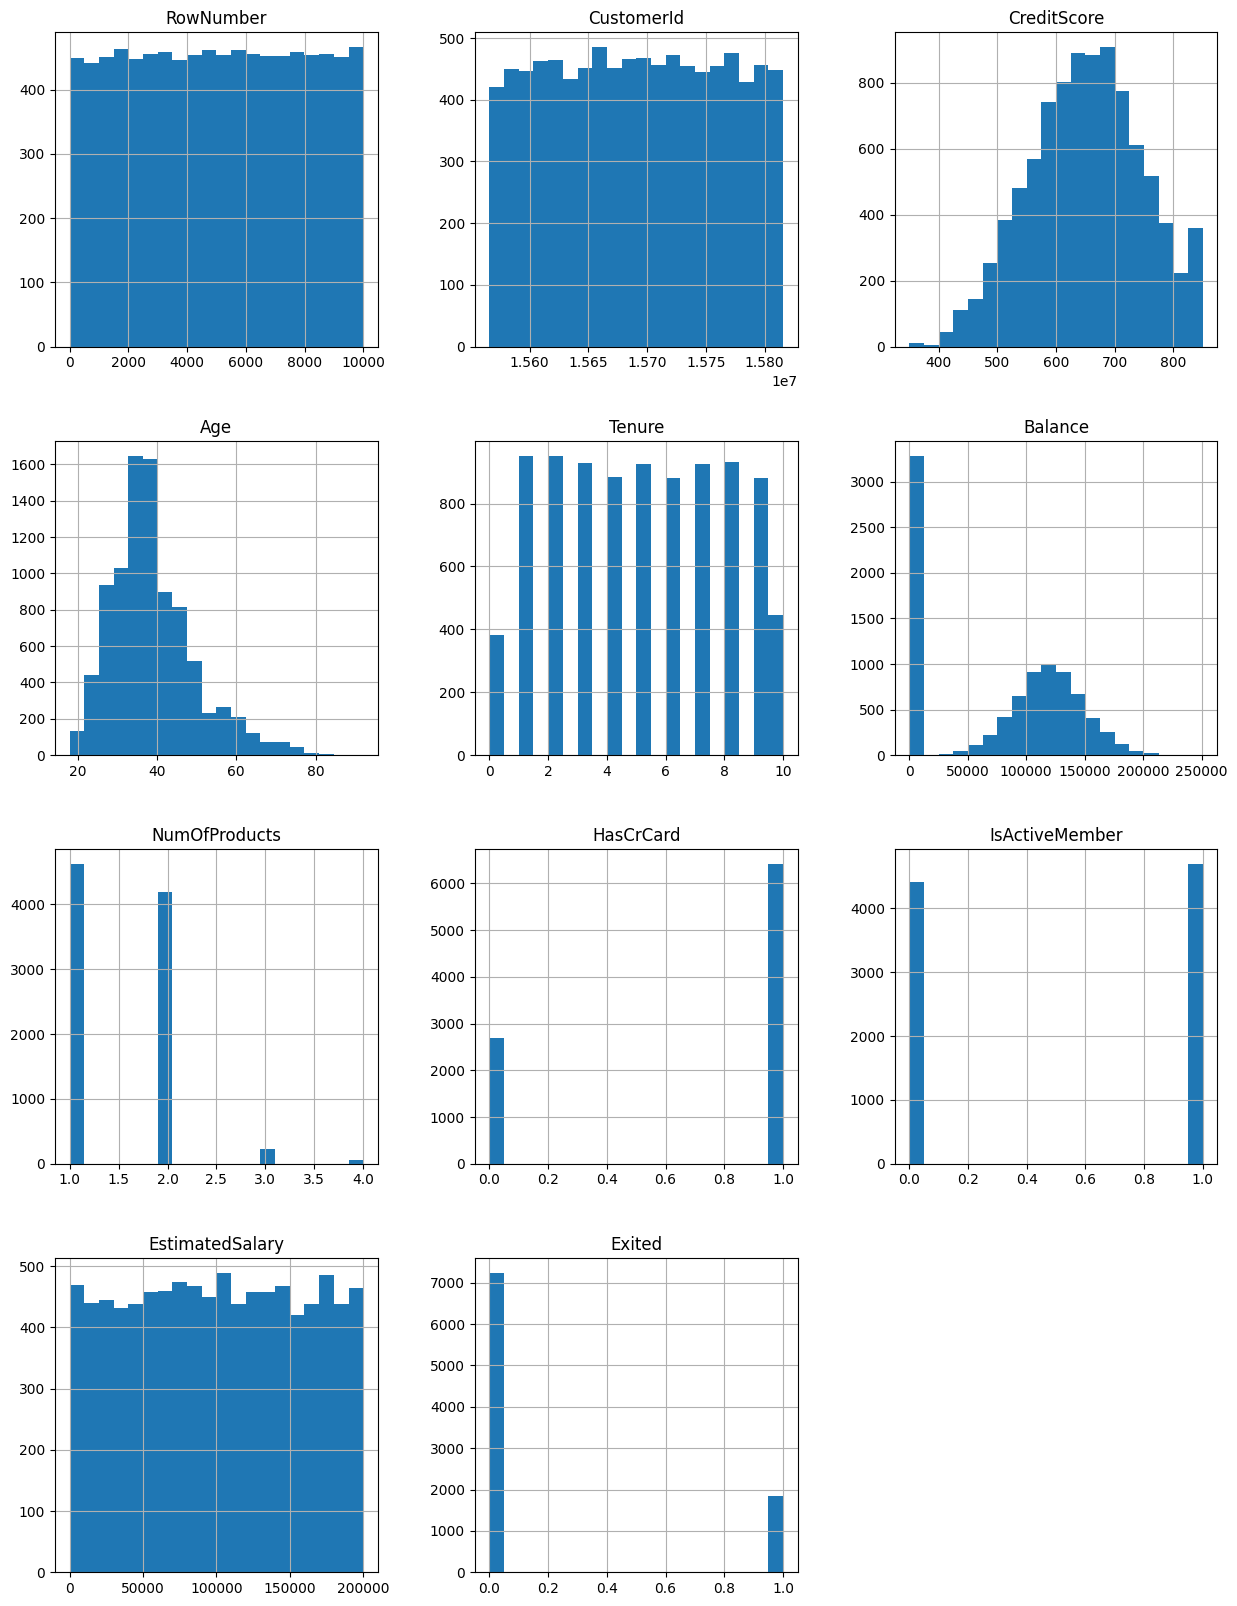

In [7]:
df.hist(figsize=(15, 20), bins=20);

*Из общей информации о данных и получившихся гистограмм видны незначащие столбцы `RowNumber` (номер строки) и `CustomerId` (id клиента) и `Surname` (фамилия), которые в качестве обучающих признаков не подойдут для нашей модели.*

*Теперь отделим целевую переменную и признаки*

In [8]:
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

*И разделим данные на обучающую и тестовую выборки в пропорции 80:20*

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7272, 10), (1819, 10), (7272,), (1819,))

In [ ]:
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, random_state=100)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=100)

*Выделим наименования числовых и категориальных признаков*

In [11]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorial = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

*Стандартизируем числовые признаки*

In [12]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
#X_val[numeric] = scaler.transform(X_val[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

*Теперь создадим функцию для OHE-кодирования категориальных столбцов*

In [13]:
ohe = OneHotEncoder(sparse=False, drop='first')
# кодирование столбца
result = ohe.fit_transform(X_train[['Geography']])
# приведение столбца к формату DataFrame с названием соответствующим категории и теми же индексами
new_cat_columns = pd.DataFrame(result, columns=ohe.categories_[0][1:], index=X_train['Geography'].index)
# добавление закодированного столбца к датафрейму с закодированными категорированными столбцами
new_cat_columns

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Germany,Spain
8335,0.0,0.0
1816,0.0,0.0
318,0.0,1.0
6319,1.0,0.0
5189,0.0,1.0
...,...,...
388,0.0,1.0
86,0.0,1.0
8855,0.0,1.0
7642,0.0,0.0


In [14]:
def ohe_encoder(x):
    encoded_categ_columns = pd.DataFrame()
    for categoty_column in x.columns:
        ohe = OneHotEncoder(sparse=False, drop='first')
        # кодирование столбца
        result = ohe.fit_transform(x[[categoty_column]])
        # приведение получившихся столбцов к формату DataFrame с названиями соответствующими категориям и теми же индексами
        new_cat_columns = pd.DataFrame(result, columns=ohe.categories_[0][1:], index=x[categoty_column].index)
        # добавление закодированного столбца к датафрейму с закодированными категорированными столбцами
        encoded_categ_columns = pd.concat([encoded_categ_columns, new_cat_columns], axis=1)
    return encoded_categ_columns

*И перепишем датафреймы с признакам, собрав числовые и категориальные столбцы*

In [15]:
X_train = pd.concat([X_train[numeric],
           ohe_encoder(X_train[categorial[:-2]]),
           X_train[categorial[-2:]]],
          axis=1)
X_test = pd.concat([X_test[numeric],
           ohe_encoder(X_test[categorial[:-2]]),
           X_test[categorial[-2:]]],
          axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [16]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Germany,Spain,Male,HasCrCard,IsActiveMember
8335,-0.035280,-0.378839,-0.347281,0.750094,-0.903784,-0.277749,0.0,0.0,1.0,1,0
1816,-1.231863,-0.946844,-0.692661,0.602959,-0.903784,-0.422167,0.0,0.0,1.0,0,0
318,-0.231272,-1.609516,-0.692661,-1.235454,-0.903784,-0.251452,0.0,1.0,0.0,1,0
6319,-0.086857,-1.893518,-0.692661,0.591968,-0.903784,1.322175,1.0,0.0,0.0,1,1
5189,1.811172,0.189166,-0.001900,1.114354,0.814469,1.405400,0.0,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
388,0.604274,0.567835,-1.038042,-1.235454,0.814469,1.092933,0.0,1.0,0.0,0,1
86,1.027204,-1.609516,-0.692661,0.716726,-0.903784,0.498266,0.0,1.0,1.0,1,0
8855,0.480489,0.378501,1.725004,0.821723,-0.903784,1.536415,0.0,1.0,1.0,0,0
7642,1.656442,0.094498,-1.383423,0.393182,-0.903784,0.378942,0.0,0.0,1.0,1,1


In [17]:
X_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Germany,Spain,Male,HasCrCard,IsActiveMember
8937,0.831212,-0.757509,-1.383423,0.890482,-0.903784,1.484023,0.0,0.0,1.0,1,1
5161,1.976218,0.662503,1.379623,-1.235454,-0.903784,-1.433841,0.0,1.0,1.0,0,0
8013,-0.004334,-0.662841,-1.038042,0.126727,-0.903784,1.098030,0.0,0.0,1.0,1,0
9628,0.119451,-1.609516,1.379623,-1.235454,0.814469,-0.963551,0.0,0.0,0.0,1,1
5995,-0.293164,1.893179,-0.001900,0.679803,-0.903784,-0.685090,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9406,2.058741,-0.757509,0.343481,0.882211,0.814469,1.367457,0.0,0.0,1.0,1,1
6992,-0.963663,-0.000169,0.688862,-0.440143,-0.903784,0.266581,0.0,0.0,0.0,1,0
8206,-0.726410,-0.473506,0.343481,-1.235454,0.814469,1.043885,0.0,0.0,1.0,1,1
1604,0.697112,-0.757509,-1.383423,1.213780,-0.903784,-1.436259,0.0,0.0,0.0,0,1


**Таким образом, мы подготовили данные для обучения моделей: произвели стандартизацию числовых признаков и OHE-кодирование категориальных признаков**

## Исследование задачи

*В данных есть дисбаланс классов целевой переменной `Exited`. Рассмотрим его в процентном соотношении*

In [18]:
df.Exited.value_counts(normalize=True)*100

0    79.606204
1    20.393796
Name: Exited, dtype: float64

*То есть клиенты покинувшие банк составляют 20 % от всех клиентов*

*Исследуем для начала модели без учёта дисбаланса классов*

*Модель логистической регрессии выберем методом `GridSearchCV`*

In [19]:
model_LR = LogisticRegression(random_state=100, solver='liblinear')
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_clf_LR = GridSearchCV(model_LR, parameters, refit='f1', cv=5, scoring=['f1', 'roc_auc'])
grid_clf_LR.fit(X_train, y_train)

print(grid_clf_LR.best_estimator_)
print(grid_clf_LR.best_params_)
print(grid_clf_LR.best_score_)

LogisticRegression(random_state=100, solver='liblinear')
{'solver': 'liblinear'}
0.3158498681333295


*Выведем метрики **f1-score** и **roc-auc-score** при перекрёстной проверке*

In [20]:
cv_results = cross_validate(grid_clf_LR.best_estimator_, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

f1-score	 0.3158498681333295
roc-auc-score	 0.7634385441373236


*В наилучшей модели **логистической регрессии** средний параметр **f1-score** принял значение примерно равное 0.32*

*Выберем дерево решений методом `GridSearchCV`*

In [21]:
model_tree = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=100)
parameters = {'criterion' : ["gini", "entropy"], 'max_depth' : range(5, 20)}

grid_clf_tree = GridSearchCV(model_tree, parameters, refit='f1', cv=5, scoring=['f1', 'roc_auc'])
grid_clf_tree.fit(X_train, y_train)

print(grid_clf_tree.best_estimator_)
print(grid_clf_tree.best_params_)
print(grid_clf_tree.best_score_)

DecisionTreeClassifier(max_depth=7, random_state=100)
{'criterion': 'gini', 'max_depth': 7}
0.5715951419648613


*Выведем метрики **f1-score** и **roc-auc-score** при перекрёстной проверке*

In [22]:
cv_results = cross_validate(grid_clf_tree.best_estimator_, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

f1-score	 0.5715951419648613
roc-auc-score	 0.8176876678721319


*В наилучшей модели **дерева решений** средний параметр **f1-score** принял значение примерно равное 0.57*

*Теперь выберем модель случайного леса методом `GridSearchCV`*

In [23]:
model_forest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10, random_state=100)
parameters = {'n_estimators': range(5,30,5), 'criterion' : ["gini", "entropy"], 'max_depth' : range(5, 20)}

grid_clf_forest = GridSearchCV(model_forest, parameters, refit='f1', cv=5, scoring=['f1', 'roc_auc'])
grid_clf_forest.fit(X_train, y_train)

print(grid_clf_forest.best_estimator_)
print(grid_clf_forest.best_params_)
print(grid_clf_forest.best_score_)

RandomForestClassifier(max_depth=15, n_estimators=25, random_state=100)
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 25}
0.5706103108797838


*Выведем метрики **f1-score** и **roc-auc-score** при перекрёстной проверке*

In [24]:
cv_results = cross_validate(grid_clf_forest.best_estimator_, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

f1-score	 0.5706103108797838
roc-auc-score	 0.8378898410893324


*В наилучшей модели **случайного леса** средний параметр **f1-score** принял значение примерно равное 0.57*

**Таким образом, без учёта дисбаланса классов наилучшие показатели f1-score и roc-auc-score (0.57 и 0.82) показали модели дерева решений и случайного леса**

## Борьба с дисбалансом

*Как уже было замечено, имеется дисбаланс классов целевой переменной `Exited`*

In [25]:
y_train.value_counts(normalize=True)*100

0    79.09791
1    20.90209
Name: Exited, dtype: float64

*Более редкого класса меньше почти в 4 раза. Необходимо произвести балансирование классов при обучении моделей. Для начала воспользуемся параметром `class_weight` со значением 'balanced'*

*Начнём так же с логистической регрессии*

In [26]:
model_LR = LogisticRegression(random_state=100, solver='liblinear', class_weight='balanced')
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_clf_LR = GridSearchCV(model_LR, parameters, refit='f1', cv=5, scoring=['f1', 'roc_auc'])
grid_clf_LR.fit(X_train, y_train)

print(grid_clf_LR.best_estimator_)
print(grid_clf_LR.best_params_)
cv_results = cross_validate(grid_clf_LR.best_estimator_, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

LogisticRegression(class_weight='balanced', random_state=100,
                   solver='newton-cg')
{'solver': 'newton-cg'}
f1-score	 0.49603531877403934
roc-auc-score	 0.7663329658619408


*С балансированием классов получили f1-score на логистической регресси выше, чем без балансирования*

*Теперь проверим для дерева решений*

In [27]:
model_tree = DecisionTreeClassifier(criterion="gini", max_depth=10, class_weight='balanced', random_state=100)
parameters = {'criterion' : ["gini", "entropy"], 'max_depth' : range(5, 20)}

grid_clf_tree = GridSearchCV(model_tree, parameters, refit='f1', cv=5, scoring=['f1', 'roc_auc'])
grid_clf_tree.fit(X_train, y_train)

print(grid_clf_tree.best_estimator_)
print(grid_clf_tree.best_params_)
cv_results = cross_validate(grid_clf_tree.best_estimator_, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, random_state=100)
{'criterion': 'entropy', 'max_depth': 6}
f1-score	 0.5638443721395452
roc-auc-score	 0.8249898958621197


*С балансированием классов на дереве решений f1-score примерно такой же как без балансирования*

*Теперь проверим для случайного леса*

In [28]:
model_forest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10, class_weight='balanced', random_state=100)
parameters = {'n_estimators': range(5,30,5), 'criterion' : ["gini", "entropy"], 'max_depth' : range(5, 20)}

grid_clf_forest = GridSearchCV(model_forest, parameters, refit='f1', cv=5, scoring=['f1', 'roc_auc'])
grid_clf_forest.fit(X_train, y_train)

print(grid_clf_forest.best_estimator_)
print(grid_clf_forest.best_params_)
cv_results = cross_validate(grid_clf_forest.best_estimator_, X_train, y_train, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, n_estimators=25, random_state=100)
{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 25}
f1-score	 0.6107596676438409
roc-auc-score	 0.8493555931863049


*С балансированием классов у модели случайного леса f1-score и roc-auc стал выше (f1-score на 0.04, roc-auc-score на 0.01)*

*Теперь применим другой метод балансировки, для этого ещё раз посчитаем соотношение классов между собой*

In [29]:
(y_train == 0).sum() / (y_train == 1).sum()

3.7842105263157895

Опираясь на это соотношение количество повторений элементов редкого класса примем равным 4

In [30]:
repeat = 4

И создадим функцию для балансирования обучающей выборки засчёт повторения редкого класса

In [31]:
def upsample(features, target, repeat):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=100)
    
    return X_upsampled, y_upsampled

Применим её к обучающей выборке

In [32]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)
X_upsampled, y_upsampled = upsample(X_train, y_train, repeat)

In [33]:
model_LR = LogisticRegression(solver='liblinear', random_state=100)
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_clf_LR = GridSearchCV(model_LR, parameters, cv=5, scoring='f1')
grid_clf_LR.fit(X_upsampled, y_upsampled)

print(grid_clf_LR.best_estimator_)
print(grid_clf_LR.best_params_)
cv_results = cross_validate(grid_clf_LR.best_estimator_, X_upsampled, y_upsampled, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

LogisticRegression(random_state=100, solver='newton-cg')
{'solver': 'newton-cg'}
f1-score	 0.7117871050731504
roc-auc-score	 0.7679772817190106


У модели логистической регрессии f1-score увеличился при данном виде балансирования классов

Проверим для дерева

In [34]:
model_tree = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=100)
parameters = {'criterion' : ["gini", "entropy"], 'max_depth' : range(5, 20)}

grid_clf_tree = GridSearchCV(model_tree, parameters, cv=5, scoring='f1')
grid_clf_tree.fit(X_upsampled, y_upsampled)

print(grid_clf_tree.best_estimator_)
print(grid_clf_tree.best_params_)
cv_results = cross_validate(grid_clf_tree.best_estimator_, X_upsampled, y_upsampled, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

DecisionTreeClassifier(max_depth=19, random_state=100)
{'criterion': 'gini', 'max_depth': 19}
f1-score	 0.9303759140503862
roc-auc-score	 0.9234912963704828


Для дерева решений при данном виде балансирования классов значительно выросли и f1 и roc-auc-score

In [35]:
model_forest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10, random_state=100)
parameters = {'n_estimators': range(5,30,5), 'criterion' : ["gini", "entropy"], 'max_depth' : range(5, 20)}

grid_clf_forest = GridSearchCV(model_forest, parameters, cv=5, scoring='f1')
grid_clf_forest.fit(X_upsampled, y_upsampled)

print(grid_clf_forest.best_estimator_)
print(grid_clf_forest.best_params_)
cv_results = cross_validate(grid_clf_forest.best_estimator_, X_upsampled, y_upsampled, cv=5, scoring=['f1', 'roc_auc'])
print('f1-score\t', cv_results['test_f1'].mean())
print('roc-auc-score\t', cv_results['test_roc_auc'].mean())

RandomForestClassifier(max_depth=18, n_estimators=20, random_state=100)
{'criterion': 'gini', 'max_depth': 18, 'n_estimators': 20}
f1-score	 0.9535012893673226
roc-auc-score	 0.9933459571892514


Так же и для случайного леса при данном виде балансирования классов значительно выросли и f1 и roc-auc-score

**Таким образом, для модели случайного леса получены наибольшие значения метрик f1-score и roc-auc-score**

## Тестирование модели

Теперь проверим наилучшую модель на тестовой выборке

In [36]:
results = pd.DataFrame({'f1-score' : [f1_score(y_test, grid_clf_forest.predict(X_test))],
                        'roc-auc-score' : [roc_auc_score(y_test, grid_clf_forest.predict_proba(X_test)[:, 1])], 
                       },
                      index=['Forest'])
results

,f1-score,roc-auc-score
Forest,0.603715,0.857118


Модель случайного леса показала значения метрик f1-score и roc-auc-score на тестовой выборке - 0.60 и 0.857 соответственно

Построим ROC-кривую для данной модели случайного леса

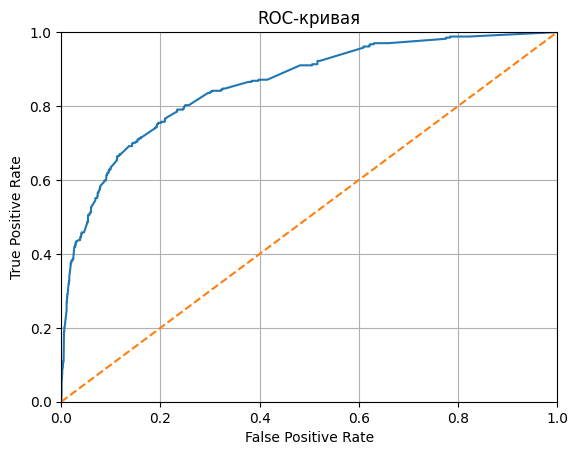

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, grid_clf_forest.predict_proba(X_test)[:, 1])

plt.figure()
# ROC-кривая модели:
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (прямая от точки (0,0) до точки (1,1))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(visible=True)
plt.show()

Выведем параметры лучшей модели случайного леса

In [39]:
grid_clf_forest.best_params_

{'criterion': 'gini', 'max_depth': 18, 'n_estimators': 20}

**Вывод**

**В ходе работы была изучена имеющаяся информация о клиентах банка. Данные были обработаны, удалены дубликаты и подготовлены обучающая и тестовая выборки. Так же был обнаружен дисбаланс классов, который был устранён путём увеличения выборки с редким классом. Была получена наилучшая модель случайного леса со следующими гиперпараметрами: криетрий - gini, максимальная глубина дерева - 18, количество деревьев - 20. Данная модель на тестовой выборке показала следующие значения метрик: f1-мера - 0.60, и roc-auc-score - 0.857**